In [3]:
"""
Import libraries, statements and utility functions
"""

import numpy as np
import matplotlib.pyplot as plt

# For California Housing experiments
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

def plot_loss_gradNorm(history, title):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history["losses"], label="Loss")
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["grad_norms"], label="Gradient Norm")
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Gradient Norm")
    plt.title(title)
    plt.legend()

    plt.tight_layout()
    plt.show()

## ELM

In [36]:
class ELM:
    """
    Extreme Learning Machine for a single-hidden-layer feedforward neural network (SLFN).
    """

    def __init__(self, input_size, hidden_size, output_size, mu, 
                 l1_lambda=0.0, activation='relu', seed=None,):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.mu = mu
        self.l1_lambda = l1_lambda

        if seed is not None:
            np.random.seed(seed)

        # Choose activation
        if isinstance(activation, str):
            if activation.lower() == 'relu':
                self.activation = self._relu
                self.activation_deriv = self._relu_derivative
            elif activation.lower() == 'tanh':
                self.activation = self._tanh
                self.activation_deriv = self._tanh_derivative
            else:
                raise ValueError("Unsupported activation string. Use 'relu' or 'tanh'.")
        else:
            # user-supplied function
            self.activation = activation
            self.activation_deriv = None

        # Randomly init input->hidden (fixed in ELM)
        if isinstance(activation, str) and activation.lower() == 'relu':
            # He initialization for ReLU
            he_std = np.sqrt(2.0 / input_size)
            self.weights_input_hidden = np.random.normal(
                loc=0.0, scale=he_std, size=(input_size, hidden_size)
            )
            self.bias_hidden = np.random.normal(
                loc=0.0, scale=1e-2, size=(1, hidden_size)
            )
        else:
            # e.g. Tanh => Xavier
            limit = np.sqrt(6.0 / (input_size + hidden_size))
            self.weights_input_hidden = np.random.uniform(
                low=-limit, high=limit, size=(input_size, hidden_size)
            )
            self.bias_hidden = np.random.uniform(
                low=-limit, high=limit, size=(1, hidden_size)
            )

        # Hidden->output weights (trainable) + bias
        limit_out = np.sqrt(6.0 / (hidden_size + output_size))
        self.weights_hidden_output = np.random.uniform(
            low=-limit_out, high=limit_out, size=(hidden_size, output_size)
        )
        self.bias_output = np.random.uniform(
            low=-limit_out, high=limit_out, size=(1, output_size)
        )

        # Forward-pass placeholders
        self.hidden_layer_input = None
        self.hidden_layer_output = None
        self.output_layer_input = None
        self.predicted_output = None

    # ---------------------------------------------------------
    # Activation utilities
    # ---------------------------------------------------------
    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_derivative(self, x):
        return (x > 0).astype(float)

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_derivative(self, x):
        y = np.tanh(x)
        return 1.0 - y*y

    # L1 subgradient helper
    def _l1_subgrad(self, w):
        grad = np.zeros_like(w)
        grad[w > 0] = 1.0
        grad[w < 0] = -1.0
        return grad

    # ---------------------------------------------------------
    # Forward / backward pass
    # ---------------------------------------------------------
    def forward(self, X):
        self.hidden_layer_input = X.dot(self.weights_input_hidden) + self.bias_hidden
        self.hidden_layer_output = self.activation(self.hidden_layer_input)
        self.output_layer_input = self.hidden_layer_output.dot(self.weights_hidden_output) + self.bias_output
        self.predicted_output = self.output_layer_input  # linear output
        return self.predicted_output

    def backward(self, X, y):
        n_samples = X.shape[0]
        output_error = (self.predicted_output - y)
        # gradient wrt (W2, b2)
        dW2 = (self.hidden_layer_output.T @ output_error) / n_samples
        db2 = np.sum(output_error, axis=0, keepdims=True) / n_samples
    
        # L1 penalty
        W2 = self.weights_hidden_output
        if self.mu:
            # Moreau envelope derivative: w_j / sqrt(w_j^2 + mu^2)
            denom = np.sqrt(W2*W2 + self.mu*self.mu)
            dW2_l1 = W2 / denom
        else:
            dW2 += self.l1_lambda * self._l1_subgrad(W2)
            
        return dW2, db2
        
    def evaluate_loss(self, X, y):
        pred = self.forward(X)
        mse = 0.5 * np.mean((pred - y)**2)
        if self.mu > 1e-15:
            # smoothed L1
            denom = np.sqrt(self.weights_hidden_output**2 + self.mu*self.mu)
            l1_smooth = np.sum(denom)
            l1_term = self.l1_lambda * l1_smooth
        else:
            # standard L1
            l1_term = self.l1_lambda * np.sum(np.abs(self.weights_hidden_output))
        return mse + l1_term
         
    # ---------------------------------------------------------
    # Parameter pack/unpack
    # ---------------------------------------------------------
    def _pack_params(self, W_out, b_out):
        """
        Flatten and concatenate trainable parameters into one vector.
        """
        return np.concatenate([W_out.ravel(), b_out.ravel()])

    def _unpack_params(self, theta):
        """
        Unpack flattened vector theta into ELM's W_out, b_out shapes.
        """
        w_size = self.hidden_size * self.output_size
        w = theta[:w_size].reshape((self.hidden_size, self.output_size))
        b = theta[w_size:].reshape((1, self.output_size))

        self.weights_hidden_output = w
        self.bias_output = b

    # ---------------------------------------------------------
    # Generic training via user-provided optimizer
    # ---------------------------------------------------------
    def train(self, X, y, optimizer, **optimizer_args):
        # Define objective function: f(theta) => (loss, gradient, _)
        def objective(theta):
            self._unpack_params(theta)
            self.forward(X)
            loss = self.evaluate_loss(X, y)
            dW2, db2 = self.backward(X, y)
            grad = self._pack_params(dW2, db2)
            return loss, grad, None

        # Pack initial parameters for the optimizer
        theta_init = self._pack_params(self.weights_hidden_output, self.bias_output)
        theta_opt, history = optimizer(objective, theta_init, **optimizer_args)
        self._unpack_params(theta_opt)
        return history

    def get_parameters(self):
        return {
            "weights_hidden_output": self.weights_hidden_output,
            "bias_output": self.bias_output
        }

    def set_parameters(self, params):
        self.weights_hidden_output = params["weights_hidden_output"]
        self.bias_output = params["bias_output"]

## Smoothed

In [99]:
def smoothed(
    f, 
    theta_init, 
    A_norm,
    epochs=1000,
    M=1.0,
    mu=1e-2,
    sigma_2=1.0,
    momentum_init=0.9,
    gradient_norm_threshold=None
):
    # 1) The Lipschitz constant
    L_L1 = (1.0 / (mu * sigma_2)) * A_norm
    L_mu = M + L_L1
    nu = min(1.0 / L_mu, 0.001)
    
    # momentum
    v = np.zeros_like(theta_init)
    theta = theta_init.copy()
    eta = momentum_init

    history = {"losses": [], "grad_norms": [], "theta": []}

    for epoch in range(epochs):
        theta_look = theta + eta * v
        loss, grad, _ = f(theta_look)
        gn = np.linalg.norm(grad)
        
        history["losses"].append(loss)
        history["grad_norms"].append(gn)
        history["theta"].append(theta_look.copy())
        
        if gradient_norm_threshold is not None and gn < gradient_norm_threshold:
            print(f"Stopping early at epoch {epoch}, grad norm < {gradient_norm_threshold}")
            break
        
        # momentum update
        v = eta * v - nu * grad
        theta = theta + v
        
        # optional update for 'eta' each epoch
        eta_candidate = 1.0 - 2.0 / (epoch + 2)
        eta = np.clip(eta_candidate, 0.9, 0.99)

    return theta, history

## Data (syn and cal)

In [61]:
def generate_synthetic_regression_data(n_samples=1000, n_features=10, noise=0.1, random_seed=42):
    """
    Generates a single-output regression dataset:
        y = sin(2*pi*x_0) + Gaussian noise
    with x in [0, 1].
    """
    np.random.seed(random_seed)
    X = np.random.rand(n_samples, n_features)  # shape (n_samples, n_features)

    # Use just the first feature for generating the target,
    # so the target y is (n_samples,) or (n_samples, 1).
    y_true = np.sin(2 * np.pi * X[:, 0])  # shape (n_samples,)

    # Add random noise
    y_noisy = y_true + noise * np.random.randn(n_samples)
    # Optionally reshape to (n_samples, 1) if your code expects 2D:
    y_noisy = y_noisy.reshape(-1, 1)

    return X, y_noisy

X_syn, y_syn = generate_synthetic_regression_data(n_samples=5000, n_features = 100, noise=0.1, random_seed=42)
# summary statistics
print(f"X shape: {X_syn.shape}, y shape: {y_syn.shape}")
print(f"X range: {X_syn.min():.2f} to {X_syn.max():.2f}")
print(f"y range: {y_syn.min():.2f} to {y_syn.max():.2f}")

X shape: (5000, 100), y shape: (5000, 1)
X range: 0.00 to 1.00
y range: -1.31 to 1.31


In [63]:
def load_california_housing_data(random_state=42):
    """
    Load and preprocess the California Housing dataset.
    """
    data = fetch_california_housing()
    X = data.data
    y = data.target.reshape(-1, 1)
    # Standardize features.
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

X_cal, y_cal = load_california_housing_data()
print(f"X shape: {X_cal.shape}, y shape: {y_cal.shape}")

X shape: (20640, 8), y shape: (20640, 1)


## Test function

[smoothed] early stop at epoch=915, grad_norm=0.00000
[smoothed] early stop at epoch=1095, grad_norm=0.00000


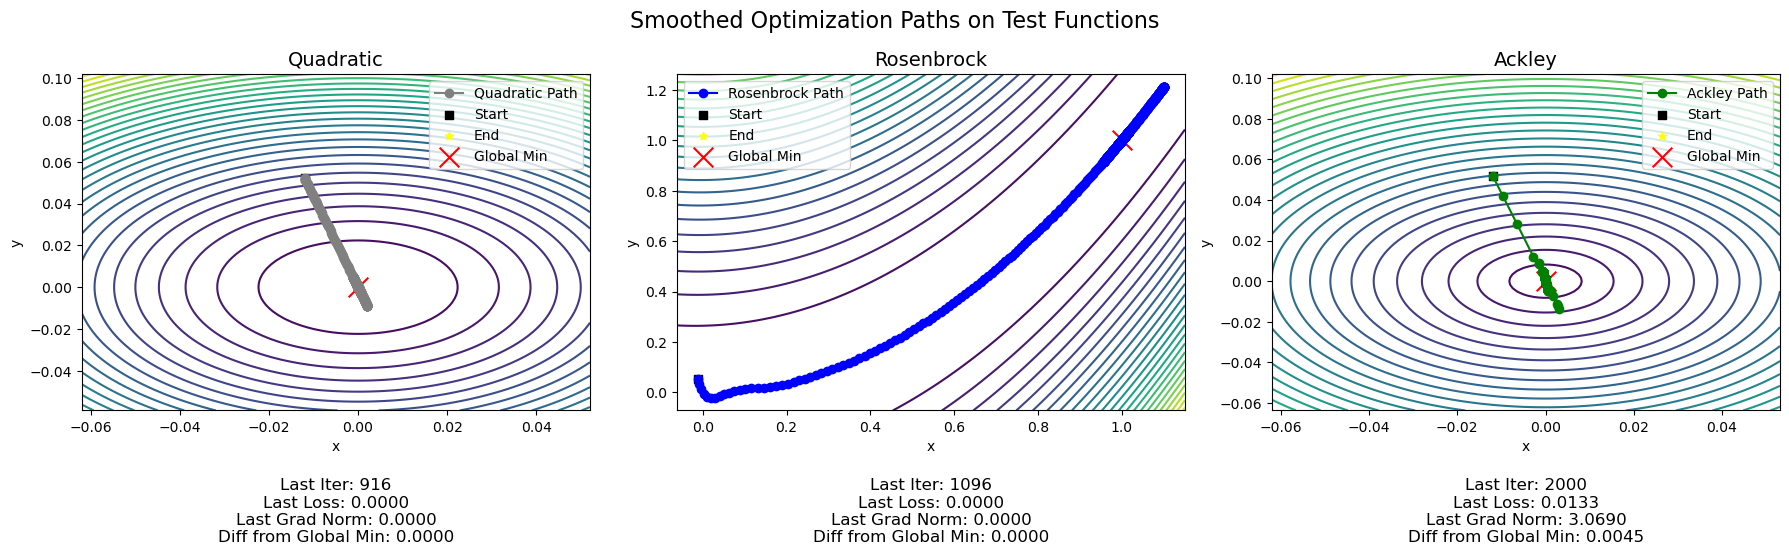

In [106]:
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
# The same test functions (Quadratic, Rosenbrock, Ackley), 
# but inside a "SmoothedTestFunctions" class
###############################################################################
class SmoothedTestFunctions:
    def __init__(self):
        """
        Produces a list of function handlers useful to test unconstrained optimization algorithms.
        Each function follows the format:
            v, g, H = f(x)
        """
        self.functions = [
            self.quadratic,
            self.rosenbrock,
            self.ackley
        ]

        # Known global minima for each function in R^2:
        self.global_minima = {
            "quadratic": np.array([0, 0]),
            "rosenbrock": np.array([1, 1]),
            "ackley": np.array([0, 0])
        }

    def quadratic(self, x, Q=None, q=None):
        """ Quadratic function: f(x) = 0.5 * x'Qx + q'x """
        if Q is None:
            Q = np.array([[2, 0],
                          [0, 2]])  # Default positive definite matrix
        if q is None:
            q = np.array([0, 0])    # Default linear term

        if x is None:
            # No input => return default or degenerate
            if np.min(np.linalg.eigvals(Q)) > 1e-14:
                x_star = np.linalg.solve(Q, -q)
                v = 0.5 * x_star.T @ Q @ x_star + q.T @ x_star
            else:
                v = -np.inf
            return v, np.array([0, 0]), Q
        else:
            v = 0.5 * x.T @ Q @ x + q.T @ x
            g = Q @ x + q
            H = Q
            return v, g, H

    def rosenbrock(self, x):
        """
        Rosenbrock function with gradient and Hessian.
        """
        if x is None:
            return 0, np.array([-1, 1]), np.array([[2, 0], [0, 200]])

        v = 100 * (x[1] - x[0]**2)**2 + (x[0] - 1)**2
        g = np.array([
            2*x[0] - 400*x[0]*(x[1] - x[0]**2) - 2,
            -200*x[0]**2 + 200*x[1]
        ])
        H = np.array([
            [1200*x[0]**2 - 400*x[1] + 2, -400*x[0]],
            [-400*x[0], 200]
        ])
        return v, g, H

    def ackley(self, x):
        """
        Ackley function with gradient and Hessian.
        """
        if x is None:
            return 0, np.array([2, 2]), None

        a, b, c = 20, 0.2, 2*np.pi
        sum_sq = np.sum(x**2) / len(x)
        sum_cos = np.sum(np.cos(c * x)) / len(x)
        v = -a * np.exp(-b * np.sqrt(sum_sq)) - np.exp(sum_cos) + a + np.e

        grad = a*b*np.exp(-b*np.sqrt(sum_sq))*(x / (np.sqrt(sum_sq)*len(x))) + (c/len(x))*np.exp(sum_cos)*np.sin(c*x)
        return v, grad, None

    ############################################################################
    # Plot function level sets & the smoothed optimizer's trajectory
    ############################################################################
    def plot_contours(self, optimizer):
        """
        Plot function level sets and the path that the smoothed optimizer took.
        'optimizer' is a function: optimizer(f) -> history dict with "trajectory"
        """
        colors = ['grey', 'blue', 'green']
        fig, axes = plt.subplots(1, len(self.functions), figsize=(18, 6))
        fig.suptitle("Smoothed Optimization Paths on Test Functions", fontsize=16)

        for i, (f, ax) in enumerate(zip(self.functions, axes)):
            # Run the user-supplied 'optimizer' on this test function
            history = optimizer(f)  # returns { "trajectory": [...], "losses": [...], "grad_norms": [...] }
            trajectory = np.array(history["trajectory"])
            # compute min / max of x and y
            x_min, x_max = np.min(trajectory[:, 0]) - 0.05, np.max(trajectory[:, 0]) + 0.05
            y_min, y_max = np.min(trajectory[:, 1]) - 0.05, np.max(trajectory[:, 1]) + 0.05

            x_vals = np.linspace(x_min, x_max, 100)
            y_vals = np.linspace(y_min, y_max, 100)
            X, Y = np.meshgrid(x_vals, y_vals)

            # Evaluate function on a grid for contour plot
            Z = np.zeros_like(X)
            for rr in range(X.shape[0]):
                for cc in range(X.shape[1]):
                    v, _, _ = f(np.array([X[rr, cc], Y[rr, cc]]))
                    Z[rr, cc] = v

            # contour lines
            ax.contour(X, Y, Z, levels=30, cmap='viridis')
            ax.plot(trajectory[:, 0], trajectory[:, 1],
                    marker='o', color=colors[i],
                    label=f'{f.__name__.capitalize()} Path')
            # Mark start & end
            ax.scatter(trajectory[0, 0], trajectory[0, 1], color='black', marker='s', label='Start')
            ax.scatter(trajectory[-1, 0], trajectory[-1, 1], color='yellow', marker='*', label='End')

            # Mark global min
            global_min = self.global_minima[f.__name__]
            ax.scatter(global_min[0], global_min[1], color='red', marker='x', label='Global Min', s=200)

            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_title(f"{f.__name__.capitalize()}", fontsize=14)
            ax.legend()

            # Some info
            last_iter = len(history["losses"])
            last_loss = history["losses"][-1] if history["losses"] else float('nan')
            last_grad_norm = history["grad_norms"][-1] if history["grad_norms"] else float('nan')
            diff = np.linalg.norm(trajectory[-1] - global_min)

            # show text
            ax.text(0.5, -0.3,
                    f"Last Iter: {last_iter}\nLast Loss: {last_loss:.4f}\nLast Grad Norm: {last_grad_norm:.4f}\nDiff from Global Min: {diff:.4f}",
                    horizontalalignment='center',
                    verticalalignment='center',
                    transform=ax.transAxes,
                    fontsize=12)

        plt.tight_layout()
        plt.show()

###############################################################################
# Wrapper code that calls your "smoothed" function
# in 2D for the test function f(x)->(value, gradient, Hessian).
###############################################################################
def smoothed_wrapper(f):
    """
    This wrapper calls 'smoothed(...)' with a 2D input, ignoring A_norm from ELM context.
    We keep it minimal so we can pass it to 'plot_contours'.
    """
    # We'll pick an initial guess
    theta_init = np.array([-0.012, 0.052], dtype=float)

    # We'll do a "fake" objective that expects a parameter x (not a big param vector).
    # So we define a custom function f_theta for smoothed that:
    #   - uses x_look as (2,) shape
    #   - returns (loss, grad, None)
    def f_2D(x_look):
        val, grad, _ = f(x_look)  # your test function
        return val, grad, None

    # We'll do a simpler momentum approach in 2D, storing "history" with "trajectory", "losses", "grad_norms"
    history = {"trajectory": [], "losses": [], "grad_norms": []}

    # For demonstration, let's pick a fixed step size or something
    M = 1.0
    mu = 1e-2
    sigma_2 = 1.0
    L_L1 = (1.0 / (mu * sigma_2)) * 0.0  # no real "A_norm" in 2D tests
    L_mu = M + L_L1
    nu = 1.0 / L_mu
    # if that's too big, clamp
    nu = min(nu, 0.001)

    v = np.zeros_like(theta_init)
    x = theta_init.copy()
    eta = 0.9
    max_iters = 2000
    grad_thresh = 1e-6

    for epoch in range(max_iters):
        x_look = x + eta*v
        val, grad, _ = f_2D(x_look)
        gn = np.linalg.norm(grad)

        history["trajectory"].append(x_look.copy())
        history["losses"].append(val)
        history["grad_norms"].append(gn)

        if gn < grad_thresh:
            print(f"[smoothed] early stop at epoch={epoch}, grad_norm={gn:.5f}")
            break

        # momentum update
        v = eta * v - nu * grad
        x = x + v

        # optional dynamic momentum
        eta_candidate = 1.0 - 2.0 / (epoch + 2)
        eta = np.clip(eta_candidate, 0.9, 0.99)

    return history

###############################################################################
# Example usage
###############################################################################

if __name__ == "__main__":
    # Create the test function object
    test_functions = SmoothedTestFunctions()

    # Plot the optimization paths for each test function using the "smoothed_wrapper"
    test_functions.plot_contours(smoothed_wrapper)

## Smoothed applied to ELM

#### Synthetic data

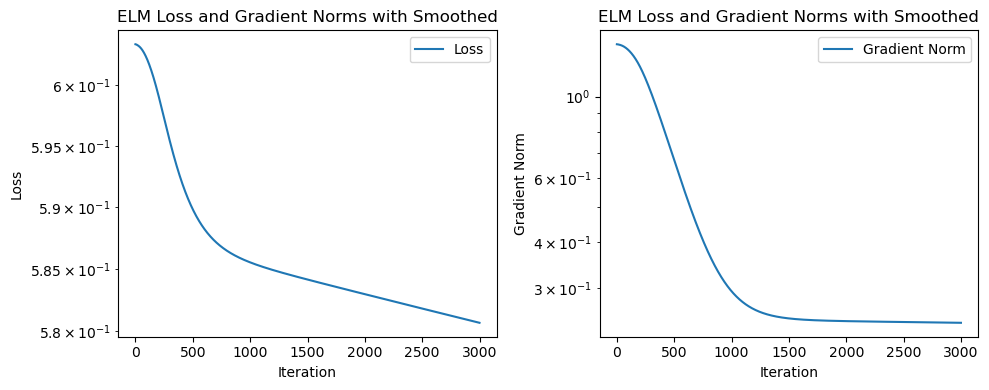

In [85]:
model = ELM(input_size=X_syn.shape[1], hidden_size=200, output_size=1,
            mu=0.1, l1_lambda=0.01, activation='relu', seed=42)


# 1) Compute the hidden activation matrix once
model.forward(X_syn)
H = model.hidden_layer_output  # shape (N, hidden_size)
A_norm = np.linalg.norm(H, ord=2)**2  # largest singular value squared


history = model.train(
    X_syn, y_syn,
    A_norm = A_norm,
    optimizer=smoothed,   
    epochs=3000,                    
    M=1.0,                        
    mu=0.1,    
    sigma_2=1.0, 
    momentum_init=0.9,
    gradient_norm_threshold=1e-5
)

plot_loss_gradNorm(history, "ELM Loss and Gradient Norms with Smoothed")

In [ ]:
# TODO: gridsearch for params discovery

##### California Housing Data

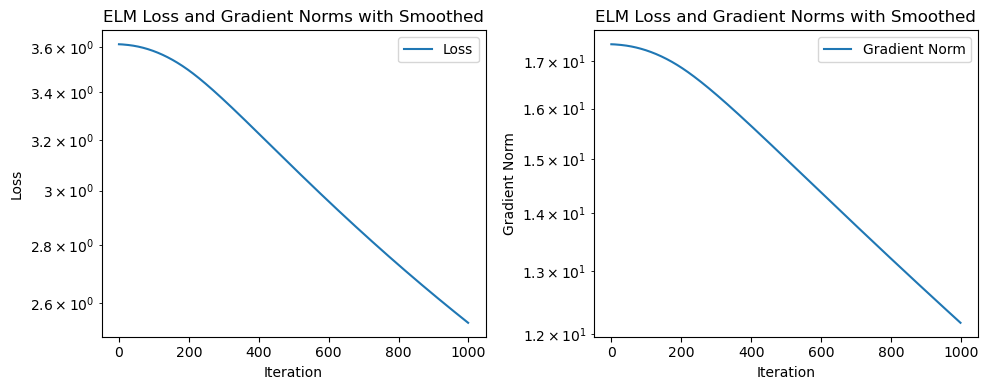

In [83]:
# CALIFORNIA HOUSING DATA
model = ELM(input_size=X_cal.shape[1], hidden_size=200, output_size=1, l1_lambda=0.01, activation='relu', mu=0.1, seed=42)

# 1) Compute the hidden activation matrix once
model.forward(X_cal)
H = model.hidden_layer_output  # shape (N, hidden_size)
A_norm = np.linalg.norm(H, ord=2)**2  # largest singular value squared

history = model.train(
    X_cal, y_cal,
    A_norm = A_norm,
    optimizer=smoothed,   
    epochs=1000,                   
    M=1.0,                       
    mu=0.1,
    sigma_2=1.0, 
    momentum_init=0.9,
    gradient_norm_threshold=1e-5
)

plot_loss_gradNorm(history, "ELM Loss and Gradient Norms with Smoothed")

In [ ]:
# TODO: gridsearch for params discovery